In [23]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py

import richio
richio.plots.use_nice_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the data

In [24]:
path = '/data1/projects/pi-rossiem/TDE_data/R0.47M0.5BH10000beta1S60n1.5ComptonHiResNewAMR/snap_76'

In [25]:
snap = richio.load(path)

/zfsstore/user/hey4/rich_tde/richio/data.py:39: UserWarning: Non-star spurious gas detected. Consider using only star particles with: data = obj[obj.star_ratio_filter()]
  warnings.warn(


In [26]:
snap.keys()

['DivV',
 'CMz',
 'Vy',
 'Vol',
 'CMy',
 'DpDy',
 'tfb',
 'DpDx',
 'CMx',
 'Diss',
 'T',
 'DpDz',
 'Vx',
 'Mass',
 'Vz',
 'Rad',
 'IE',
 'box',
 'P',
 'Den',
 'Entropy',
 'Star']

In [27]:
# Take a look at the data
print('Total number of particles in the snapshot:', len(snap))
# print('Number of cpus used for the run:', snap.rank)

Total number of particles in the snapshot: 57429866


In [28]:
# Fetch the data points, downsampled
f = snap['Den', ::10000]
x = snap['CMx', ::10000]
y = snap['CMy', ::10000]
z = snap['CMz', ::10000]
# star = snap['tracers/Star']

In [29]:
mask = snap.star_ratio_filter()
mask = mask[::10000]

f[~mask] = 0            # set density to zero

In [30]:
len(f)

5743

In [31]:
snap['box']

unyt_array([-3668.09361195, -3845.81167103, -2610.37095683,  2710.66866035,
        2214.53871241,  3051.17767999], 'code_length')

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


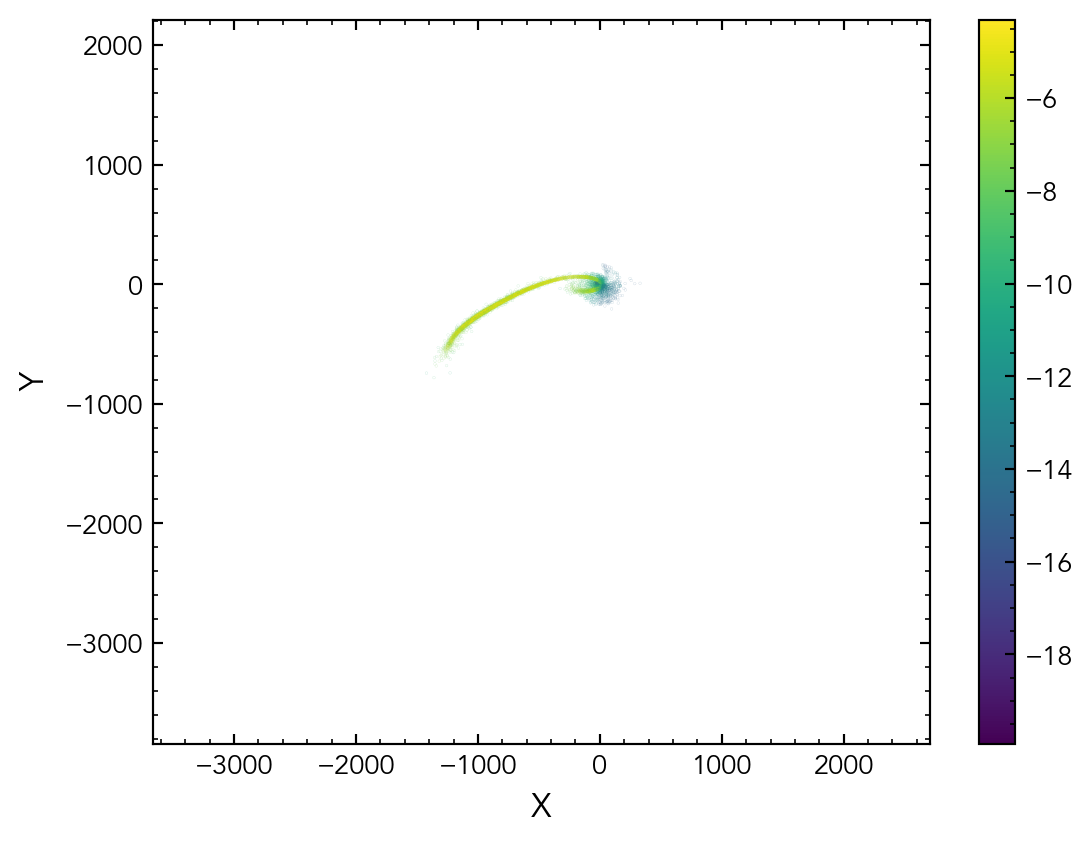

In [32]:
import matplotlib.pyplot as plt
plt.scatter(x=x, y=y, c=np.log10(f.in_cgs()), s=0.001)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(snap['box'][0], snap['box'][3])
plt.ylim(snap['box'][1], snap['box'][4])
plt.colorbar()
plt.show()

In [33]:
# plt.scatter(x=x, y=z, c=np.log10(f), s=0.001)
# plt.xlabel('X')
# plt.ylabel('Z')
# plt.xlim(snap['box'][0], snap['box'][3])
# plt.ylim(snap['box'][2], snap['box'][5])
# plt.colorbar(label='$\\log(\\rho)$')
# plt.show()

In [34]:
# plt.scatter(x=y, y=z, c=np.log10(f), s=0.001)
# plt.xlabel('Y')
# plt.ylabel('Z')
# plt.xlim(snap['box'][1], snap['box'][4])
# plt.ylim(snap['box'][2], snap['box'][5])
# plt.colorbar(label='log(density)')
# plt.show()

## Nearest Neighbor Interpolation

### NN: KDTree

In [35]:
from scipy.spatial import KDTree

res = 512
x0, y0, z0, x1, y1, z1 = snap['box']        # Load the box size

xlinspace = np.linspace(x0, x1, res)
ylinspace = np.linspace(y0, y1, res)
zlinspace = np.linspace(z0, z1, res)

X, Y, Z = np.meshgrid(xlinspace, ylinspace, zlinspace, indexing='ij')

coords = np.stack([x, y, z], axis=-1)
np.shape(coords)

(5743, 3)

In [ ]:
tree = KDTree(coords)       # build tree, this takes no time

In [37]:
grid_coords = np.stack([X, Y, Z], axis=-1)

In [38]:
np.shape(grid_coords)

(512, 512, 512, 3)

In [39]:
# Scipy query
d, i = tree.query(grid_coords, k=1, eps=0.0, p=2, workers=1) # also have a parallel processing process

### ANN: hnswlib

In [40]:
# import hnswlib
# num_elements = len(coords)
# # Declaring index
# p = hnswlib.Index(space='l2', dim=3) # possible options are l2, cosine or ip
# # Initializing index - the maximum number of elements should be known beforehand
# p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

# coords_flat = coords.reshape((num_elements, 3))
# ids = np.arange(num_elements)
# p.add_items(coords_flat, ids)

# # higher number: higher precision
# p.set_ef(50)

In [41]:
# grid_coords_flat = grid_coords.reshape((res**3, 3))
# labels, distances = p.knn_query(grid_coords_flat, k = 1)

In [42]:
# np.shape(labels)

### ANN: Annoy

In [43]:
# from annoy import AnnoyIndex
# import numpy as np

# # Parameters
# res = 512
# n_trees = 10  # More trees = higher precision but slower build time

# # Load the box size
# x0, y0, z0, x1, y1, z1 = snap['box']

# # Create coordinate arrays
# xlinspace = np.linspace(x0, x1, res)
# ylinspace = np.linspace(y0, y1, res)
# zlinspace = np.linspace(z0, z1, res)
# X, Y, Z = np.meshgrid(xlinspace, ylinspace, zlinspace, indexing='ij')

# # Original particle coordinates
# coords = np.stack([x, y, z], axis=-1)
# print(f"Coords shape: {np.shape(coords)}")

# # Build Annoy index (3D coordinates)
# n_particles = coords.shape[0]
# annoy_index = AnnoyIndex(3, 'euclidean')  # 3 dimensions, Euclidean distance

# # Add all particles to the index
# for idx in range(n_particles):
#     annoy_index.add_item(idx, coords[idx])

# # Build the index with specified number of trees
# annoy_index.build(n_trees)

# # Prepare grid coordinates for querying
# grid_coords = np.stack([X, Y, Z], axis=-1)
# print(f"Grid coords shape: {np.shape(grid_coords)}")

# # Flatten grid for easier querying
# grid_shape = grid_coords.shape
# grid_flat = grid_coords.reshape(-1, 3)

# # Query Annoy index for each grid point
# # search_k parameter controls precision (higher = more accurate but slower)
# # search_k = -1 uses default (n_trees * n), roughly equivalent to eps=0.01
# search_k = n_trees * 100  # Adjust for desired precision/speed tradeoff

# i = np.zeros(len(grid_flat), dtype=int)
# d = np.zeros(len(grid_flat), dtype=float)

# for idx, point in enumerate(grid_flat):
#     # get_nns_by_vector returns indices and distances
#     indices, distances = annoy_index.get_nns_by_vector(
#         point, 
#         1,  # k=1 nearest neighbor
#         search_k=search_k,
#         include_distances=True
#     )
#     i[idx] = indices[0]
#     d[idx] = distances[0]

# # Reshape results back to grid shape
# i = i.reshape(grid_shape[:-1])
# d = d.reshape(grid_shape[:-1])

# print(f"Query complete. Result shapes: i={i.shape}, d={d.shape}")

## Plotting

In [44]:
# Get the interpolated field based on kdtree
grid_f = f[i]

/home/hey4/.conda/envs/richanalysis/lib/python3.13/site-packages/unyt/array.py:1832: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


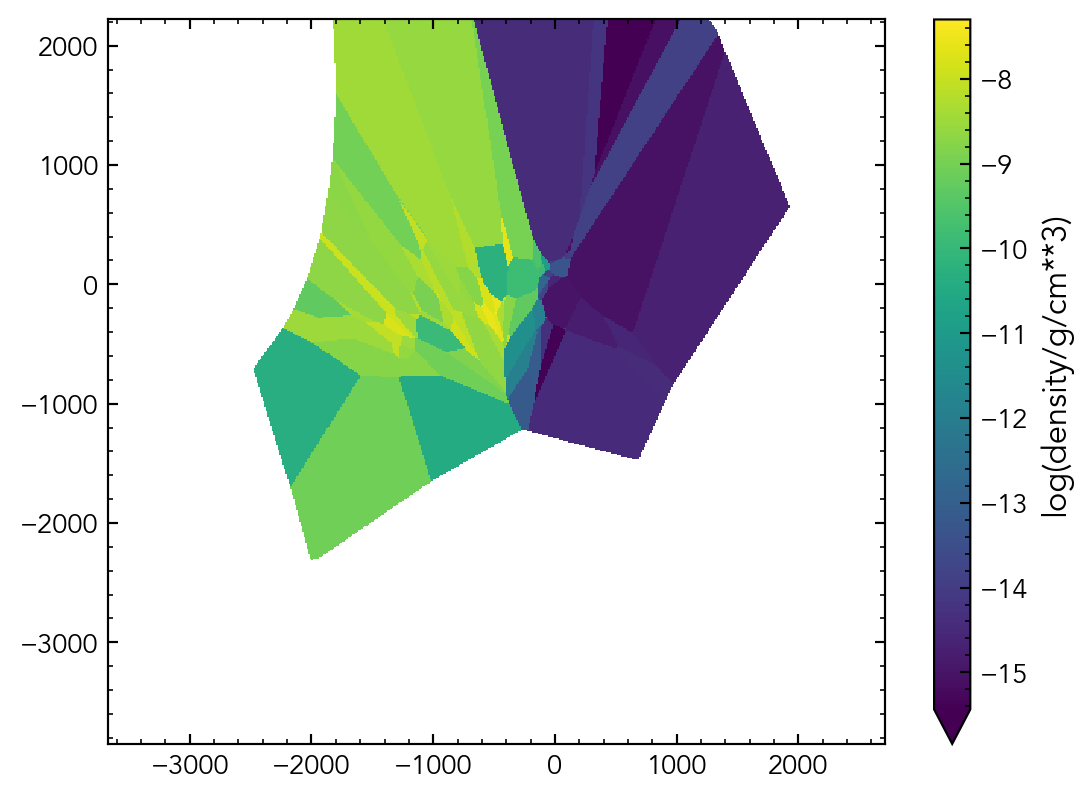

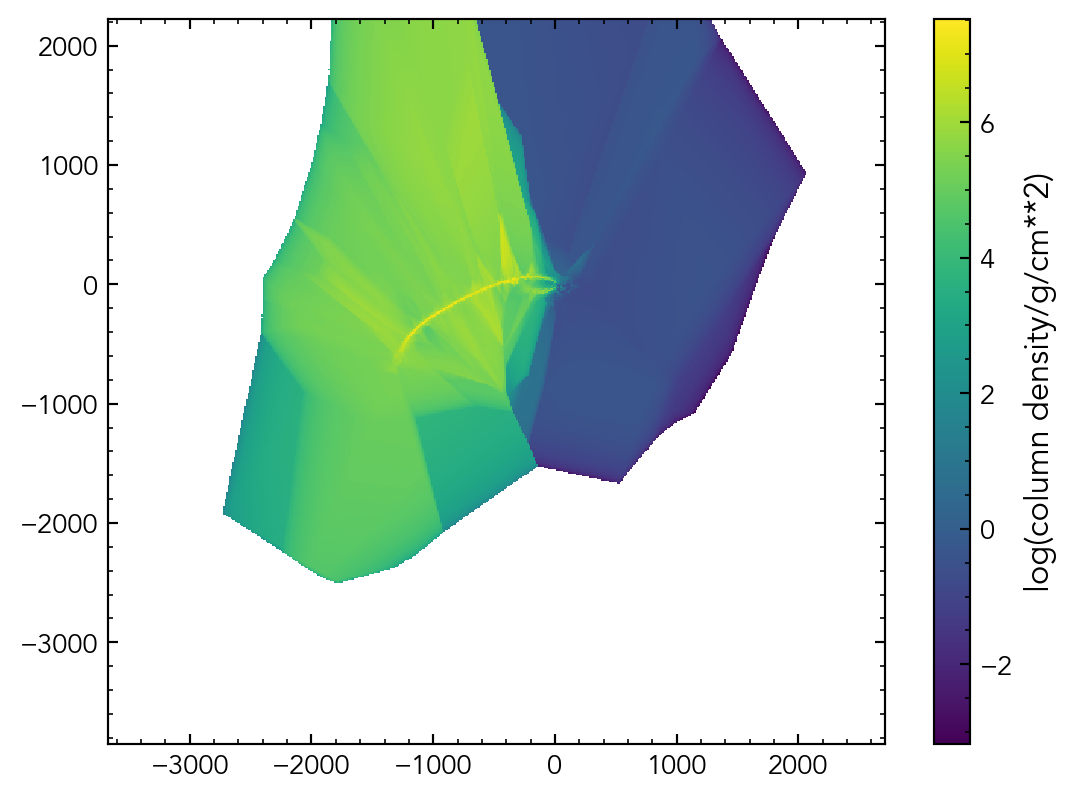

In [58]:
import matplotlib.pyplot as plt

xlinspace = np.linspace(snap['box'][0], snap['box'][3], res)
ylinspace = np.linspace(snap['box'][1], snap['box'][4], res)
xx, yy = np.meshgrid(xlinspace, ylinspace, indexing='ij')
plt.pcolormesh(xx, yy, np.log10(grid_f[:, :, 256].in_cgs()))
plt.colorbar(label=f"log(density/{grid_f.in_cgs().units})", extend='min')
plt.savefig('../reports/figures/slice.png', dpi=300, bbox_inches='tight')
plt.show()

# Projection
dz = (z1 - z0)/res
plt.pcolormesh(xx, yy, 
    np.log10(np.sum(grid_f*dz, axis=-1).in_cgs()),
    )
plt.colorbar(label=f"log(column density/{(grid_f*dz).in_cgs().units})")
plt.savefig('../reports/figures/projection.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Things you can do with unyt
print(grid_f.in_cgs().units.latex_repr)
print(grid_f.units.is_code_unit)
print(grid_f.in_cgs().units.is_code_unit)

\frac{\rm{g}}{\rm{cm}^{3}}
True
False
